In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt  # type: ignore

In [3]:
from dspy.hdb import get_dataset

In [4]:
RCS = [f"{coin}USDT" for coin in ["BTC", "ETH", "XRP", "SOL", "DOGE"]]
TIMES = ["250615.000100", "250624.215000"]

# <font color="grey">Data loading and handling</font>

Data is available in two forms: limit order book (LOB) and data sampled at fixed intervals (for example, seconds). The timestamps are given in nanosecond resolution as Unix timestamps, but the granularity of the data is not that fine. A simple dataloader and some helper function to convert Python datetime objects or strings of the form '240802.1450' into timestamps are provided. The 'book' data contains the bid and ask prices and volumes up to a specified depth (the maximum depth is currently 25).

In [5]:
# At the moment, we are only concerned with data available through the Tardis dataset.
dl = get_dataset("tardis")

####  <a id='chapter1'> <font color="grey">1. Limit Order Book</font></a>

In [7]:
df = dl.load_book("BTCUSDT", TIMES, depth=10)

In [8]:
df.shape

(14105160, 42)

In [9]:
# Add human readable timestamp and mid prices
df = df.ds.add_datetime("ts")
df.head()

ts,ts_local,asks[0].price,asks[0].amount,bids[0].price,bids[0].amount,asks[1].price,asks[1].amount,bids[1].price,bids[1].amount,asks[2].price,asks[2].amount,bids[2].price,bids[2].amount,asks[3].price,asks[3].amount,bids[3].price,bids[3].amount,asks[4].price,asks[4].amount,bids[4].price,bids[4].amount,asks[5].price,asks[5].amount,bids[5].price,bids[5].amount,asks[6].price,asks[6].amount,bids[6].price,bids[6].amount,asks[7].price,asks[7].amount,bids[7].price,bids[7].amount,asks[8].price,asks[8].amount,bids[8].price,bids[8].amount,asks[9].price,asks[9].amount,bids[9].price,bids[9].amount,dts
i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,datetime[ns]
1749945660012000000,1749945660013768000,105378.6,16.907,105378.5,8.632,105378.7,0.514,105378.4,0.171,105378.8,0.515,105378.3,1.398,105378.9,0.514,105378.2,0.002,105379.0,0.559,105378.0,0.188,105379.1,0.012,105377.9,0.002,105379.2,0.03,105377.5,0.005,105379.3,0.015,105377.4,2.664,105379.4,0.021,105377.3,0.1,105379.7,0.743,105376.4,0.072,2025-06-15 00:01:00.012
1749945660064000000,1749945660066738000,105378.6,16.926,105378.5,8.629,105378.7,0.514,105378.4,0.171,105378.8,0.515,105378.3,1.398,105378.9,0.514,105378.2,0.002,105379.0,0.559,105378.0,0.188,105379.1,0.012,105377.9,0.002,105379.2,0.03,105377.5,0.005,105379.3,0.015,105377.4,2.664,105379.4,0.021,105377.3,0.1,105379.7,0.743,105376.4,0.072,2025-06-15 00:01:00.064
1749945660116000000,1749945660118072000,105378.6,17.202,105378.5,8.63,105378.7,0.514,105378.4,0.171,105378.8,0.515,105378.3,1.398,105378.9,0.512,105378.2,0.002,105379.0,0.557,105378.0,0.188,105379.1,0.012,105377.9,0.002,105379.2,0.03,105377.5,0.005,105379.3,0.015,105377.4,2.664,105379.4,0.021,105377.3,0.1,105379.7,0.743,105376.4,0.072,2025-06-15 00:01:00.116
1749945660169000000,1749945660171689000,105378.6,17.265,105378.5,8.63,105378.7,0.514,105378.4,0.171,105378.8,0.515,105378.3,1.398,105378.9,0.514,105378.2,0.002,105379.0,0.559,105378.0,0.188,105379.1,0.012,105377.9,0.002,105379.2,0.03,105377.5,0.005,105379.3,0.015,105377.4,2.664,105379.4,0.021,105377.3,0.1,105379.7,0.743,105376.4,0.072,2025-06-15 00:01:00.169
1749945660220000000,1749945660223083000,105378.6,17.006,105378.5,8.622,105378.7,0.514,105378.4,0.171,105378.8,0.515,105378.3,1.398,105378.9,0.514,105378.2,0.002,105379.0,0.559,105378.0,0.188,105379.1,0.012,105377.9,0.002,105379.2,0.03,105377.5,0.005,105379.3,0.015,105377.4,2.664,105379.4,0.021,105377.3,0.1,105379.7,0.743,105376.4,0.072,2025-06-15 00:01:00.220


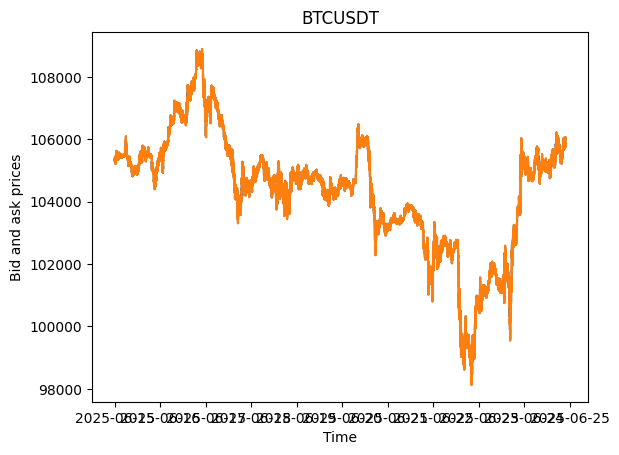

In [10]:
plt.plot(df["dts"], df["asks[0].price"], df["dts"], df["bids[0].price"])
plt.xlabel("Time")
plt.ylabel("Bid and ask prices")
plt.title(f"{RCS[0]}")
plt.show()

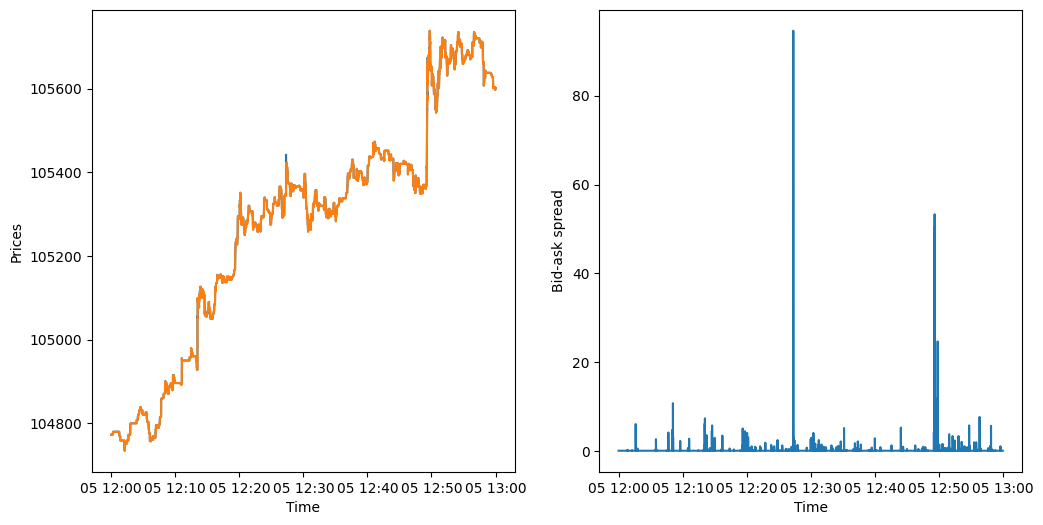

In [11]:
df = dl.load_book("BTCUSDT", ["250605.120000", "250605.130000"], depth=1)
df = df.ds.add_datetime("ts")
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(df["dts"], df["asks[0].price"], df["dts"], df["bids[0].price"])
ax[1].plot(df["dts"], df["asks[0].price"] - df["bids[0].price"])
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Prices")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Bid-ask spread")
plt.show()

####  <a id='chapter2'> <font color="grey">2. Fixed-frequency data (bars)</font></a>

In [12]:
df = dl.load_bar(
    ["BTCUSDT", "ETHUSDT"], ["250605.120000", "250605.150000"], col="mid", freq="1s"
)

In [13]:
df.head()

ts,mid_BTCUSDT,mid_ETHUSDT
datetime[ns],f64,f64
2025-06-05 12:00:01,104772.75,2606.635
2025-06-05 12:00:02,104772.75,2606.635
2025-06-05 12:00:03,104772.75,2606.655
2025-06-05 12:00:04,104772.75,2606.655
2025-06-05 12:00:05,104772.75,2606.655


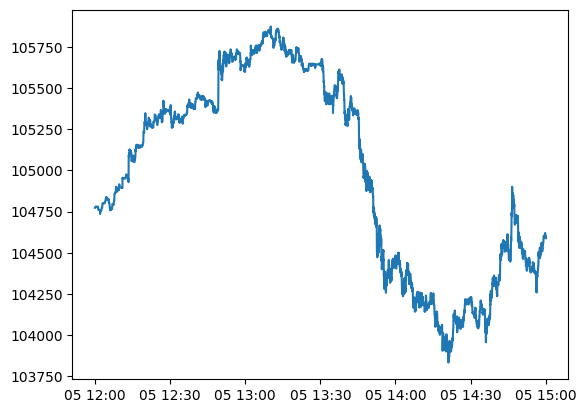

In [14]:
plt.plot(df["ts"], df["mid_BTCUSDT"])
plt.show()